# Prédire le risque de surentraînement
## Objectif : Utiliser les caractéristiques instantanées pour estimer si cette personne est à risque de surentraînement ou non, en se basant sur des corrélations entre les variables.
### Variables clés à analyser :
- **Resting_BPM** : Un Resting_BPM élevé peut indiquer un stress physiologique.
- **Fat_Percentage** et BMI : Un déséquilibre peut suggérer un métabolisme perturbé.
- **Workout_Frequency et Session_Duration** : Une fréquence ou durée excessive peut être un facteur de risque.
- **Calories_Burned** : Un nombre anormalement bas ou élevé par rapport à la moyenne du groupe.
- **Experience_Level** : Les débutants et les athlètes expérimentés n’ont pas les mêmes risques.

### Import

In [43]:
import pandas as pd
import numpy as np

### Consolidation des datas
Nous avons 2 datasets qui possèdent les mêmes colonnes, nous allons les unir pour en former qu'un et en faire un csv.

In [44]:
df1 = pd.read_csv('exercise_tracking.csv')
df1.head()

,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI
0,56,Male,88.3,1.71,180,157,60,1.69,1313.0,Yoga,12.6,3.5,4,3,30.20
1,46,Female,74.9,1.53,179,151,66,1.30,883.0,HIIT,33.9,2.1,4,2,32.00
2,32,Female,68.1,1.66,167,122,54,1.11,677.0,Cardio,33.4,2.3,4,2,24.71
3,25,Male,53.2,1.70,190,164,56,0.59,532.0,Strength,28.8,2.1,3,1,18.41
4,38,Male,46.1,1.79,188,158,68,0.64,556.0,Strength,29.2,2.8,3,1,14.39


In [45]:
df2 = pd.read_csv('exercise_tracking_synthetic_data.csv')
df2.head()

,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI
0,34.0,Female,86.7,1.86,174,152.0,74.0,1.12,712.0,Strength,12.8,2.4,5.0,2.0,14.31
1,26.0,Female,84.7,1.83,166,156.0,73.0,1.00,833.0,Strength,27.9,2.8,5.0,2.0,33.49
2,22.0,Male,64.8,1.85,187,166.0,64.0,1.24,1678.0,Cardio,28.7,1.9,3.0,2.0,12.73
3,54.0,Female,75.3,1.82,187,169.0,58.0,1.45,628.0,Cardio,31.8,2.4,4.0,1.0,20.37
4,34.0,Female,52.8,1.74,177,169.0,66.0,1.60,1286.0,Strength,26.4,3.2,4.0,2.0,20.83


In [46]:
df1.shape, df2.shape

((973, 15), (1800, 15))

In [47]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 973 entries, 0 to 972
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Age                            973 non-null    int64  
 1   Gender                         973 non-null    object 
 2   Weight (kg)                    973 non-null    float64
 3   Height (m)                     973 non-null    float64
 4   Max_BPM                        973 non-null    int64  
 5   Avg_BPM                        973 non-null    int64  
 6   Resting_BPM                    973 non-null    int64  
 7   Session_Duration (hours)       973 non-null    float64
 8   Calories_Burned                973 non-null    float64
 9   Workout_Type                   973 non-null    object 
 10  Fat_Percentage                 973 non-null    float64
 11  Water_Intake (liters)          973 non-null    float64
 12  Workout_Frequency (days/week)  973 non-null    int

In [48]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Age                            1790 non-null   float64
 1   Gender                         1729 non-null   object 
 2   Weight (kg)                    1778 non-null   float64
 3   Height (m)                     1774 non-null   float64
 4   Max_BPM                        1779 non-null   object 
 5   Avg_BPM                        1770 non-null   float64
 6   Resting_BPM                    1781 non-null   float64
 7   Session_Duration (hours)       1777 non-null   float64
 8   Calories_Burned                1777 non-null   float64
 9   Workout_Type                   1739 non-null   object 
 10  Fat_Percentage                 1784 non-null   float64
 11  Water_Intake (liters)          1776 non-null   float64
 12  Workout_Frequency (days/week)  1742 non-null   f

In [49]:
# Convertir les types de df2 en type de df1 car c'est les plus cohérentes
for col in df1.columns:
    dtype = df1[col].dtype
    if dtype == 'int64':
        df2[col] = pd.to_numeric(df2[col], errors='coerce').fillna(0).astype('int64') # on forme la conversion en cas d'erreur
    elif dtype == 'float64':
        df2[col] = pd.to_numeric(df2[col], errors='coerce').fillna(0.0)
    else:
        df2[col] = df2[col].astype(dtype)

# Vérifier les types
print(df2.dtypes)

Age                                int64
Gender                            object
Weight (kg)                      float64
Height (m)                       float64
Max_BPM                            int64
Avg_BPM                            int64
Resting_BPM                        int64
Session_Duration (hours)         float64
Calories_Burned                  float64
Workout_Type                      object
Fat_Percentage                   float64
Water_Intake (liters)            float64
Workout_Frequency (days/week)      int64
Experience_Level                   int64
BMI                              float64
dtype: object


In [50]:
df = pd.concat([df1, df2], ignore_index=True)
df.shape

(2773, 15)

In [51]:
df.to_csv('consolidated_exercise_tracking.csv', index=False)

In [52]:
df.head()

,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI
0,56,Male,88.3,1.71,180,157,60,1.69,1313.0,Yoga,12.6,3.5,4,3,30.20
1,46,Female,74.9,1.53,179,151,66,1.30,883.0,HIIT,33.9,2.1,4,2,32.00
2,32,Female,68.1,1.66,167,122,54,1.11,677.0,Cardio,33.4,2.3,4,2,24.71
3,25,Male,53.2,1.70,190,164,56,0.59,532.0,Strength,28.8,2.1,3,1,18.41
4,38,Male,46.1,1.79,188,158,68,0.64,556.0,Strength,29.2,2.8,3,1,14.39


Description des variables : les principales variables du jeu de données sont :

- Resting_BPM : rythme cardiaque au repos. Un rythme élevé peut traduire de la fatigue ou du stress.

- Fat_Percentage : pourcentage de masse grasse. Informe sur l’équilibre corporel et l’état de forme général.

- BMI : indice de masse corporelle. Sert à évaluer la corpulence et certains risques associés.

- Workout_Frequency : nombre de séances d’entraînement par semaine. Une fréquence très élevée peut indiquer une surcharge potentielle.

- Session_Duration : durée moyenne d’une séance. Des séances longues peuvent refléter une intensité soutenue.

- Calories_Burned : calories dépensées par séance. Donne une idée de l’effort fourni.

- Experience_Level : niveau estimé (débutant à expert). Influence la manière dont la charge d’entraînement est gérée.

In [53]:
df.shape

(2773, 15)

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2773 entries, 0 to 2772
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Age                            2773 non-null   int64  
 1   Gender                         2702 non-null   object 
 2   Weight (kg)                    2773 non-null   float64
 3   Height (m)                     2773 non-null   float64
 4   Max_BPM                        2773 non-null   int64  
 5   Avg_BPM                        2773 non-null   int64  
 6   Resting_BPM                    2773 non-null   int64  
 7   Session_Duration (hours)       2773 non-null   float64
 8   Calories_Burned                2773 non-null   float64
 9   Workout_Type                   2712 non-null   object 
 10  Fat_Percentage                 2773 non-null   float64
 11  Water_Intake (liters)          2773 non-null   float64
 12  Workout_Frequency (days/week)  2773 non-null   i

Les types de données sont cohérents. Seules deux colonnes présentent des valeurs manquantes : “Gender” et “Workout_Type”, mais la proportion reste faible. t

In [55]:
df.describe()

,Age,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI
count,2773.000000,2773.000000,2773.000000,2773.000000,2773.000000,2773.000000,2773.000000,2773.000000,2773.000000,2773.000000,2773.000000,2773.000000,2773.00000
mean,35.827624,69.262604,1.717083,178.290660,143.802380,62.906599,1.332625,980.115038,23.888604,2.655139,3.263253,1.781464,21.48026
std,12.593311,21.396771,0.208606,21.332486,21.157348,9.341346,0.386121,326.777542,6.298444,0.715767,1.041323,0.780250,7.33063
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,25.000000,54.400000,1.630000,170.000000,132.000000,56.000000,1.090000,758.000000,20.700000,2.100000,3.000000,1.000000,16.06000
50%,35.000000,66.800000,1.730000,180.000000,144.000000,64.000000,1.320000,966.000000,24.900000,2.700000,3.000000,2.000000,20.75000
75%,47.000000,82.300000,1.820000,190.000000,158.000000,71.000000,1.560000,1187.000000,28.200000,3.300000,4.000000,2.000000,25.68000
max,59.000000,129.900000,2.000000,199.000000,169.000000,74.000000,2.000000,1783.000000,35.000000,3.700000,5.000000,3.000000,49.84000


**Interprétation :**  

En observant, plusieurs variables présentent des minimums à 0. Certaines de ces valeurs sont clairement incohérentes (ex. âge ou taille), tandis que d’autres peuvent être plausibles. 

- Age, Weight, Height, Max_BPM, Avg_BPM, Resting_BPM, BMI, Fat_Percentage : Une valeur de 0 n’est pas réaliste. Ce sont donc des valeurs à supprimer.

- Session_Duration et Calories_Burned : Un zéro peut être logique si aucune séance n’a été réalisée.

- Workout_Frequency : Un 0 est cohérent pour une personne qui n’a pas fait de sport cette semaine, on peut donc les garder.

- Water_Intake : 0 litre pourrait indiquer un oubli de saisie plutôt qu’une vraie mesure. À vérifier.
  
- Experience_Level : La variable commence normalement à 1.  Une valeur de 0 n’est donc pas valide, à supprimer.

Vérifions le nombres de "0" incohérents dans les colonnes

In [56]:
cols = ['Age', 'Height (m)', 'Weight (kg)', 'Max_BPM', 'Avg_BPM', 'Resting_BPM', 'Fat_Percentage', 'Experience_Level', 'BMI']
for c in cols:
    print(c, (df[c] == 0).sum())

Age 10
Height (m) 26
Weight (kg) 22
Max_BPM 28
Avg_BPM 30
Resting_BPM 19
Fat_Percentage 16
Experience_Level 57
BMI 30


Suppression des lignes ayant des "0" pas logique 

In [57]:
df = df[(df['Age'] != 0) & (df['Height (m)'] != 0) & (df['Weight (kg)'] != 0) & (df['Max_BPM'] != 0) & (df['Avg_BPM'] != 0) & (df['Resting_BPM'] != 0) & (df['Fat_Percentage'] != 0) & (df['Experience_Level'] != 0) & (df['BMI'] != 0)]

verification du nombre de lignes restant 

In [58]:
df.shape # 233 lignes supprimées

(2540, 15)

Verification des doublons

In [59]:
df.duplicated().sum()

0

Verification des valeurs manquantes 

In [60]:
df.isnull().sum()

Age                               0
Gender                           62
Weight (kg)                       0
Height (m)                        0
Max_BPM                           0
Avg_BPM                           0
Resting_BPM                       0
Session_Duration (hours)          0
Calories_Burned                   0
Workout_Type                     55
Fat_Percentage                    0
Water_Intake (liters)             0
Workout_Frequency (days/week)     0
Experience_Level                  0
BMI                               0
dtype: int64

In [61]:
(df.isnull().sum() / len(df)) * 100   # pourcentage de Nan pr chaq colonne 

Age                              0.000000
Gender                           2.440945
Weight (kg)                      0.000000
Height (m)                       0.000000
Max_BPM                          0.000000
Avg_BPM                          0.000000
Resting_BPM                      0.000000
Session_Duration (hours)         0.000000
Calories_Burned                  0.000000
Workout_Type                     2.165354
Fat_Percentage                   0.000000
Water_Intake (liters)            0.000000
Workout_Frequency (days/week)    0.000000
Experience_Level                 0.000000
BMI                              0.000000
dtype: float64

Le dataset est globalement très complet : seules deux colonnes présentent des valeurs manquantes. 
"Gender" n 2,44 % de valeurs nulles et "Workout_Type"en an 2,17 %. Ces proportions restent faible, on va donc supprimer les lignes avec des Nan..


Suppression des valeurs manquantes

In [62]:
df.dropna(subset=['Gender', 'Workout_Type'], inplace = True)

In [63]:
df.isnull().sum() # plus de valeurs manquantes 

Age                              0
Gender                           0
Weight (kg)                      0
Height (m)                       0
Max_BPM                          0
Avg_BPM                          0
Resting_BPM                      0
Session_Duration (hours)         0
Calories_Burned                  0
Workout_Type                     0
Fat_Percentage                   0
Water_Intake (liters)            0
Workout_Frequency (days/week)    0
Experience_Level                 0
BMI                              0
dtype: int64

### Affichage de la matrice de corrélation 

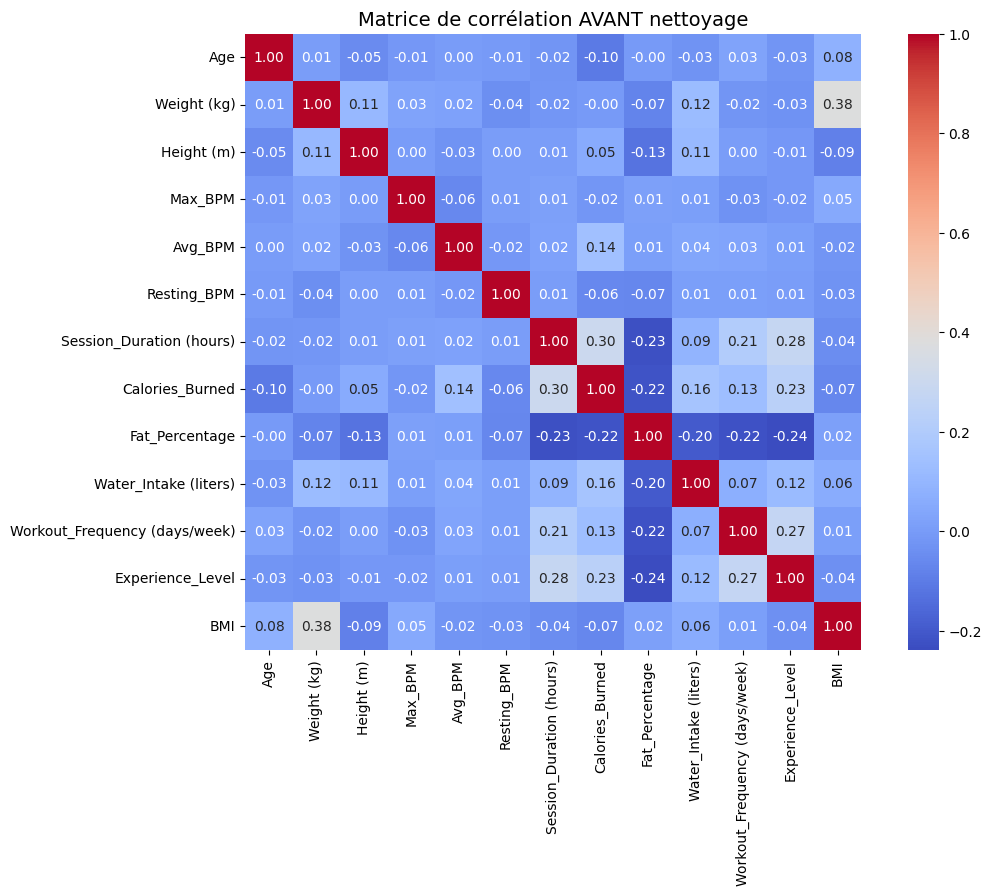

In [64]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sélectionner uniquement les colonnes numériques
numeric_cols = df.select_dtypes(include=['number']).columns

# Calcul de la matrice de corrélation
corr_matrix = df[numeric_cols].corr()

# Affichage de la matrice sous forme de heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Matrice de corrélation AVANT nettoyage", fontsize=14)
plt.show()

- Interprétation de la matrice de corrélation

Les corrélations restent globalement faibles, mais plusieurs relations cohérentes apparaissent.

On observe par exemple que le poids est modérément lié au BMI (0.38), ce qui est logique puisque le calcul en dépend directement. La durée d'entraînement montre également une corrélation positive (0.30) avec les calories brûlées et, dans une moindre mesure, avec le niveau d’expérience (0.28) : les personnes plus expérimentées ont tendance à s’entraîner plus longtemps et à brûler davantage de calories. Le pourcentage de masse grasse présente plusieurs corrélations négatives, notamment avec la fréquence d’entraînement (-0.24), la durée des séances (-0.23) et les calories dépensées (-0.22). Cela reflète simplement qu’un entraînement plus régulier ou plus intense est souvent associé à un taux de graisse plus faible.

L’hydratation suit une tendance similaire, avec de légers liens positifs avec les calories brûlées et le poids, ce qui reste cohérent. L'absence de fortes corrélations (toutes < 0.40) suggère que le risque de surentraînement ne dépend probablement pas d'une seule variable, mais d'un ensemble de facteurs combinés.
Enfin, le Resting_BPM apparaît quasiment indépendant des autres variables (corrélations très faibles). Cela en fait un indicateur intéressant à considérer séparément. 

### Visualisation de la distribution de chaque variable numérique.

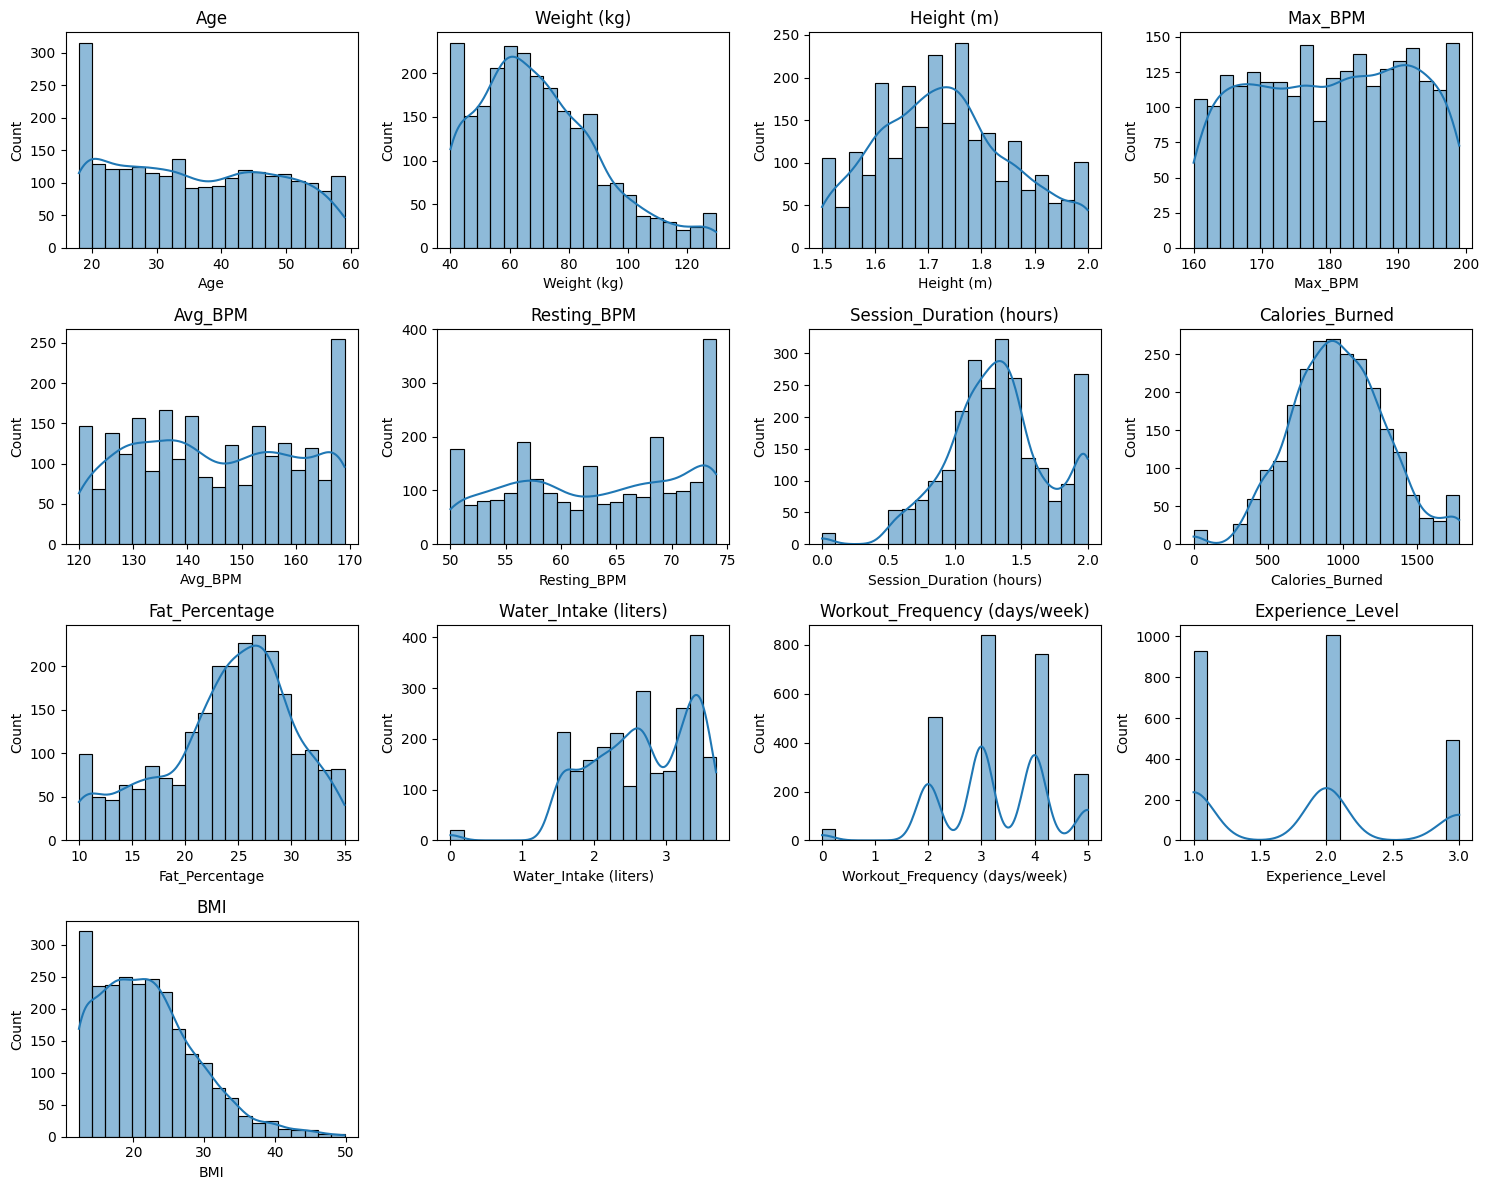

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_cols = df.select_dtypes(include=['number']).columns

plt.figure(figsize=(15, 12))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(4, 4, i)
    sns.histplot(df[col], kde=True, bins=20)
    plt.title(col)
plt.tight_layout()
plt.show()

- Interprétation
  
En regardant les histogrammes, la plupart des variables ont une distribution globalement cohérente, mais certaines montrent des formes irrégulières. Ça suggère déjà la présence possible de valeurs extrêmes dans plusieurs colonnes.

Les variables comme Weight, BMI, Workout_Frequency, Water_Intake et Session_Duration présentent une dispersion assez large ou des répartitions peu symétriques. Celà laisse penser que certains individus se situent clairement en dehors des valeurs habituelles.
À l’inverse, les variables cardiaques (Max_BPM, Avg_BPM, Resting_BPM) sont beaucoup plus resserrées et régulières ; elles semblent donc moins concernées par d’éventuels outliers.
Pour Age, Fat_Percentage et Height, la distribution reste bien centrée autour de valeurs réalistes, sans forme suspecte particulière.

Enfin, Calories_Burned montre une variabilité importante, ce qui est logique vu les différences d’intensité d’entraînement, même si cela peut aussi inclure quelques cas extrêmes.érents.


### Détection des outliers grâce aux boxplots

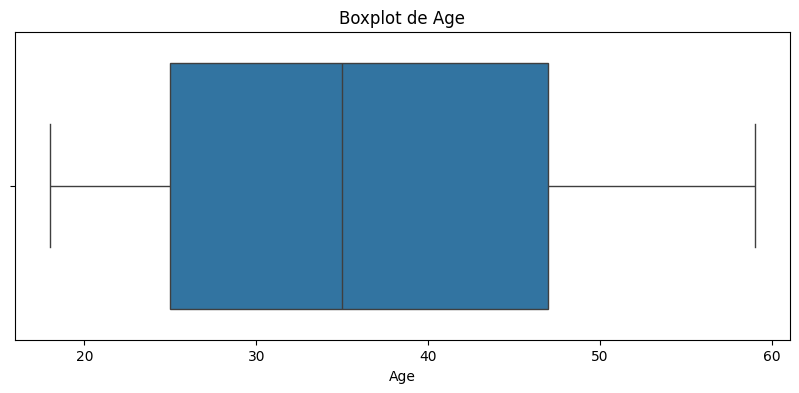

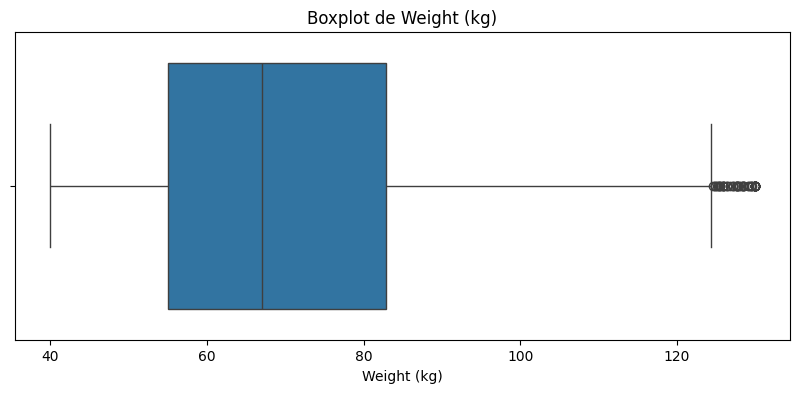

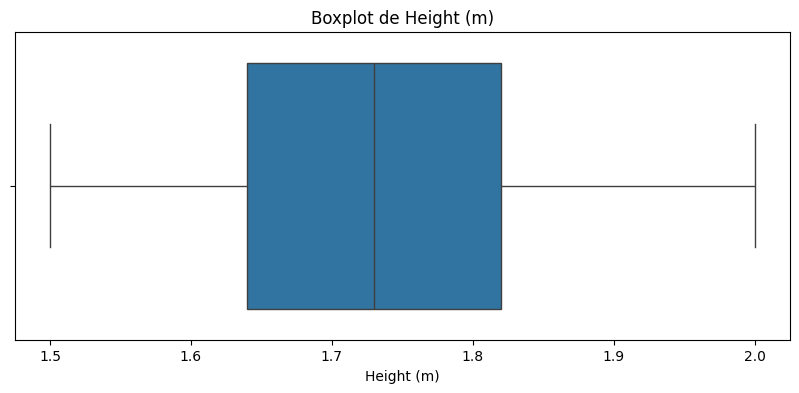

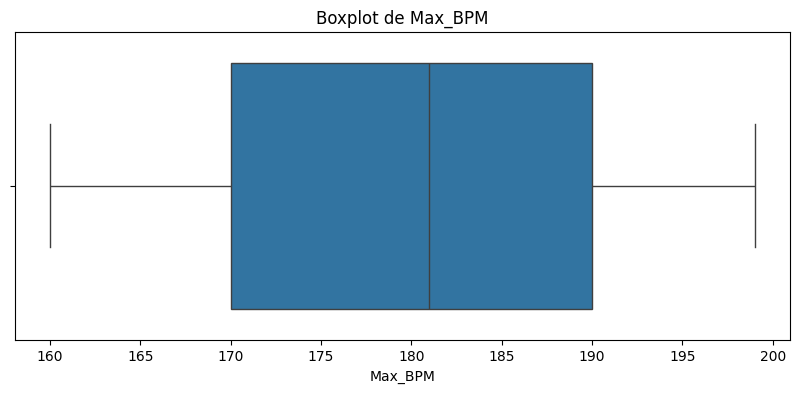

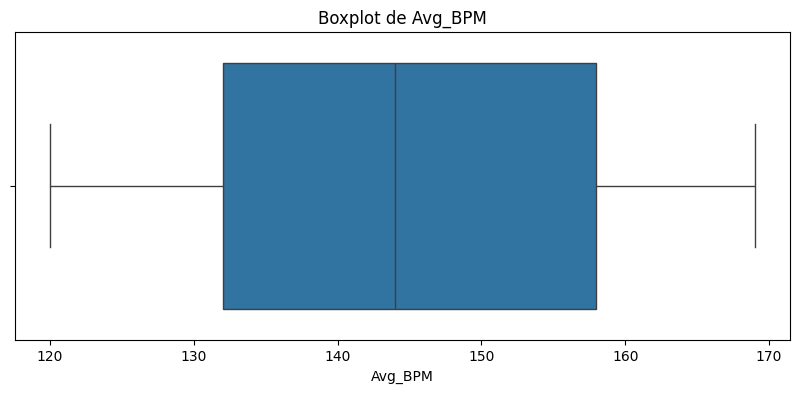

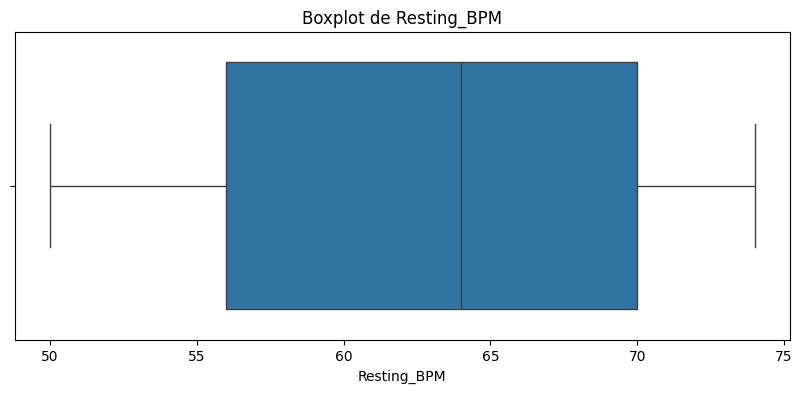

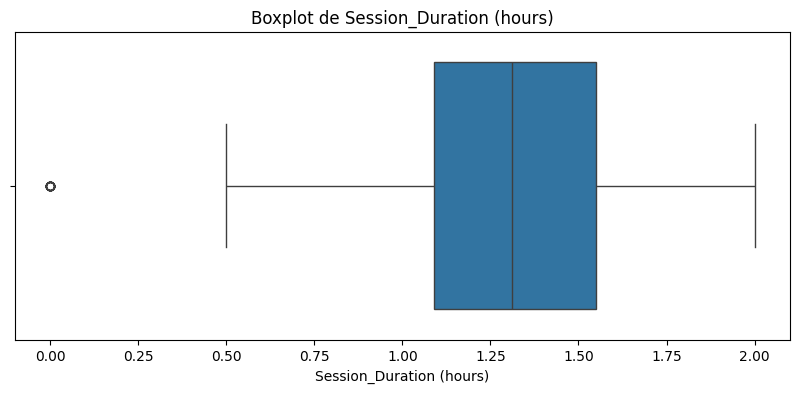

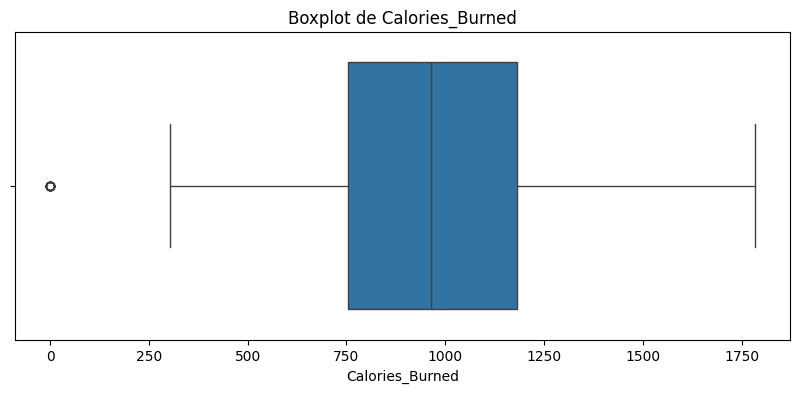

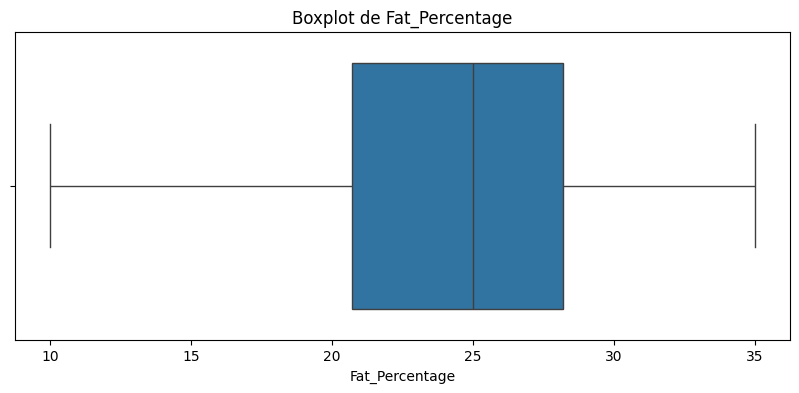

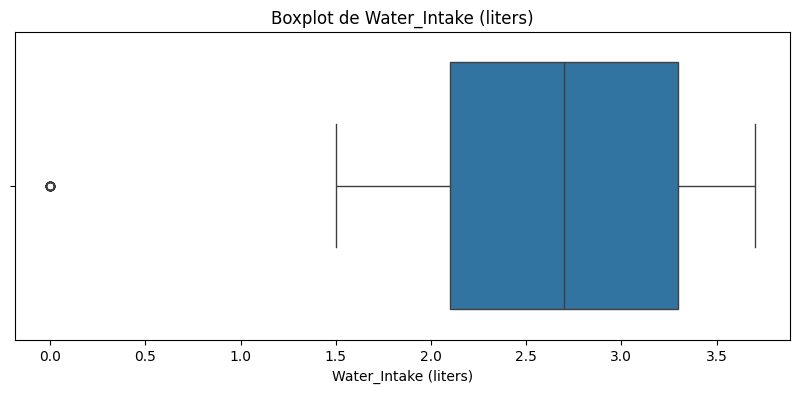

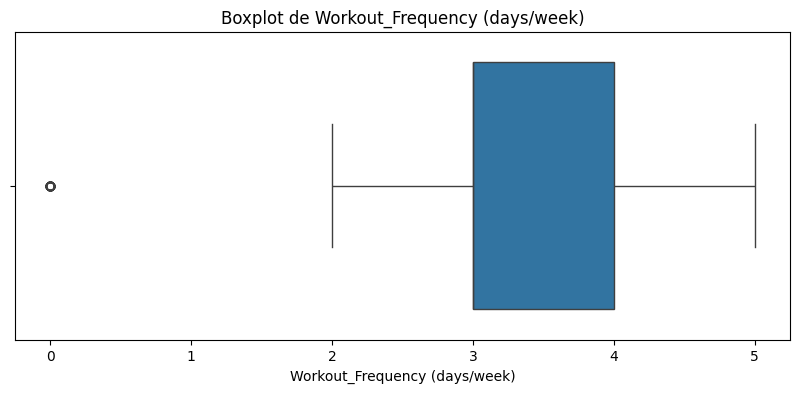

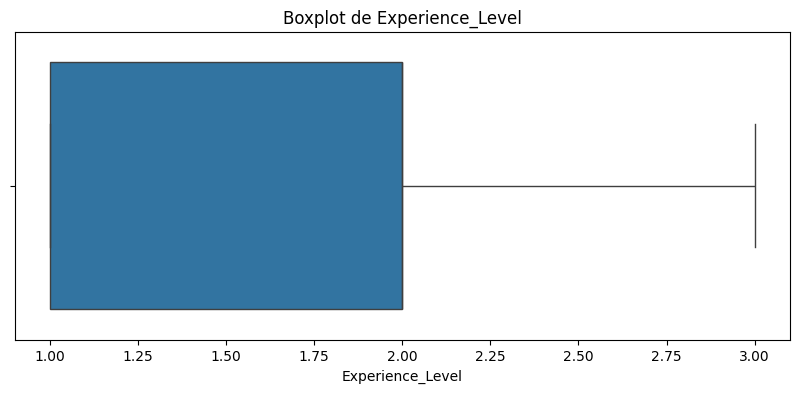

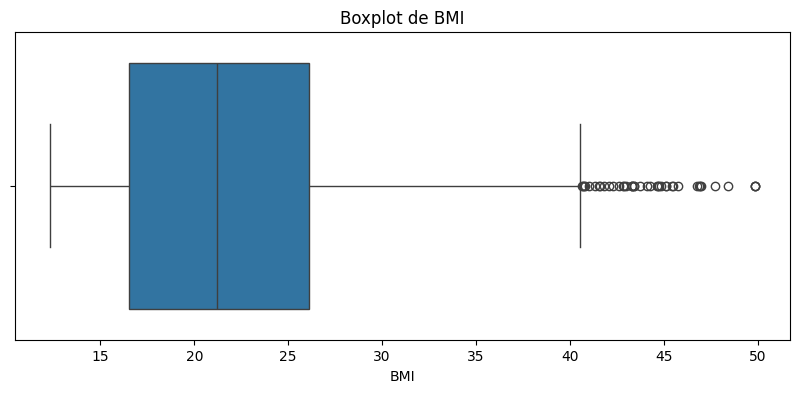

In [66]:
import seaborn as sns

def afficher_outliers(df):
    for col in df.select_dtypes(include='number').columns:
        plt.figure(figsize=(10, 4))
        sns.boxplot(data=df, x=col)
        plt.title(f"Boxplot de {col}")
        plt.show()

afficher_outliers(df)

- Affichage du nombre d'outliers par colonnes

In [67]:
for col in df.select_dtypes(include='number').columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    print(f"{col}: {len(outliers)} valeurs aberrantes")

Age: 0 valeurs aberrantes
Weight (kg): 46 valeurs aberrantes
Height (m): 0 valeurs aberrantes
Max_BPM: 0 valeurs aberrantes
Avg_BPM: 0 valeurs aberrantes
Resting_BPM: 0 valeurs aberrantes
Session_Duration (hours): 18 valeurs aberrantes
Calories_Burned: 19 valeurs aberrantes
Fat_Percentage: 0 valeurs aberrantes
Water_Intake (liters): 21 valeurs aberrantes
Workout_Frequency (days/week): 47 valeurs aberrantes
Experience_Level: 0 valeurs aberrantes
BMI: 41 valeurs aberrantes


- Interprétation
  
Les résultats montrent que certaines variables présentent un nombre important de valeurs extrêmes. Weight, BMI, Workout_Frequency, Water_Intake et Session_Duration sont les colonnes les plus concernées, ce qui confirme ce qu’on observait déjà sur les histogrammes : la variabilité était anormale.
À l’inverse, les variables physiologiques comme Age, Height, Max_BPM, Avg_BPM, Resting_BPM, Fat_Percentage et Experience_Level ne semblent pas contenir d’outliers selon la méthode IQR.

On peut dire alors que les anomalies se concentrent surtout sur les variables liées au comportement d’entraînement (fréquence, durée, hydratation) et sur les indicateurs de morphologie. Ce sont donc celles qu’il faudra traiter avant l'application des modéles.

- Remplacement par la médiane 

In [68]:
def traiter_outliers_iteratif(df, colonnes):
    """
    Traite les outliers par remplacement médiane ITÉRATIF
    jusqu'à ce qu'il n'y en ait plus (comme ton projet télécom)
    """
    df_clean = df.copy()
    
    for col in colonnes:
        iteration = 0
        while True:
            iteration += 1
            # Recalculer Q1, Q3, IQR à CHAQUE itération
            Q1 = df_clean[col].quantile(0.25)
            Q3 = df_clean[col].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR
            
            # Identifier les outliers
            outliers_mask = (df_clean[col] < lower) | (df_clean[col] > upper)
            n_outliers = outliers_mask.sum()
            
            if n_outliers == 0:
                print(f" {col}: {iteration} itération(s)")
                break  # Plus d'outliers, on arrête
            
            # Remplacer par la médiane ACTUELLE (recalculée)
            median = df_clean[col].median()
            df_clean.loc[outliers_mask, col] = median
    
    return df_clean

# Application
cols_numeriques = df.select_dtypes(include='number').columns
df= traiter_outliers_iteratif(df, cols_numeriques)

 Age: 1 itération(s)
 Weight (kg): 4 itération(s)
 Height (m): 1 itération(s)
 Max_BPM: 1 itération(s)
 Avg_BPM: 1 itération(s)
 Resting_BPM: 1 itération(s)
 Session_Duration (hours): 2 itération(s)
 Calories_Burned: 2 itération(s)
 Fat_Percentage: 1 itération(s)
 Water_Intake (liters): 2 itération(s)
 Workout_Frequency (days/week): 2 itération(s)
 Experience_Level: 1 itération(s)
 BMI: 5 itération(s)


- Pourquoi le choix de la médiane ?

J'ai choisi de remplacer les outliers par la médiane plutôt que de les supprimer pour deux raisons principales. D'abord, cela permet de conserver l'intégralité des observations sans réduire la taille du dataset, ce qui est important pour maintenir la puissance statistique des analyses. Ensuite, la médiane est une mesure robuste qui n'est pas influencée par les valeurs extrêmes, contrairement à la moyenne. En remplaçant les outliers par la médiane de chaque variable, on ramène ces valeurs aberrantes vers une valeur typique et représentative de la distribution, sans introduire de biais. 

### VISUALISATIONS Aprés nettoyage 

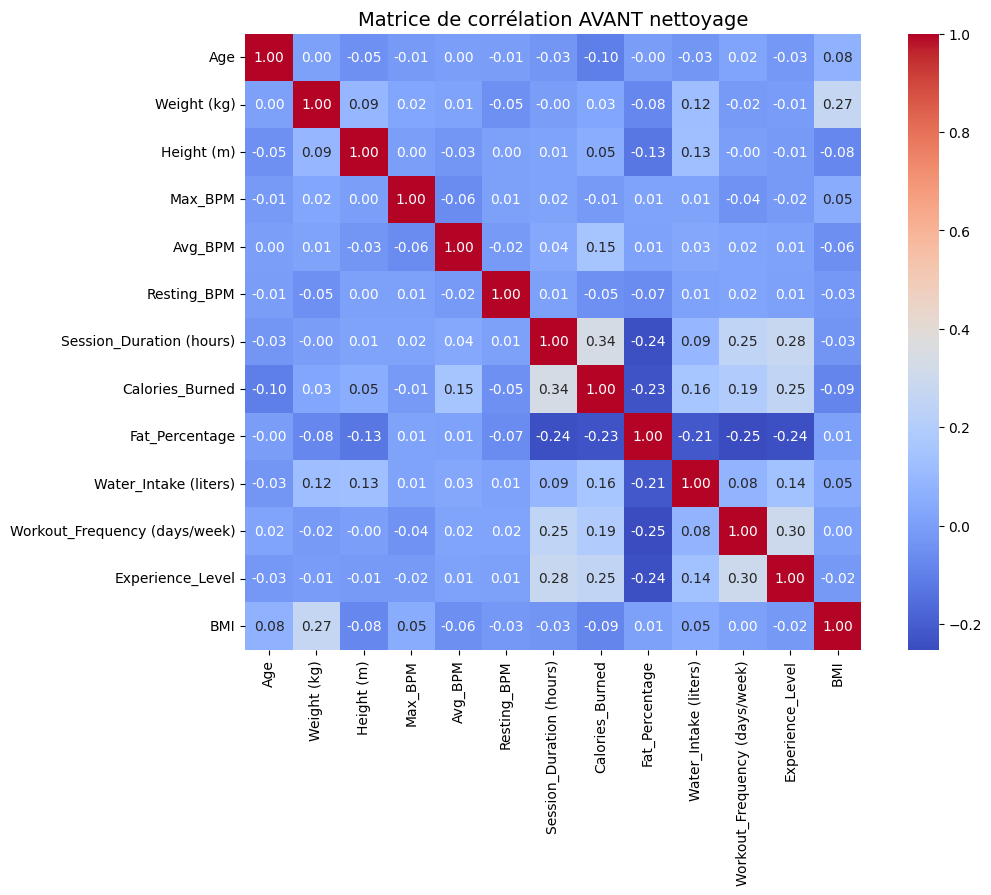

In [69]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sélectionner uniquement les colonnes numériques
numeric_cols = df.select_dtypes(include=['number']).columns

# Calcul de la matrice de corrélation
corr_matrix = df[numeric_cols].corr()

# Affichage de la matrice sous forme de heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Matrice de corrélation AVANT nettoyage", fontsize=14)
plt.show()

- Interprétation
  
Après le nettoyage du dataset, la matrice de corrélation reste globalement cohérente et confirme les tendances observées avant traitement. Les liens entre les variables liées à l’entraînement, comme la durée des séances, les calories brûlées, la fréquence hebdomadaire et le niveau d’expérience, restent présents, ce qui montre que ces dimensions évoluent ensemble de manière logique. Globalement, le nettoyage n’a pas modifié la structure du dataset : il a surtout rendu les corrélations plus réalistes en supprimant les effets des valeurs aberrantes, tout en conservant les liens principaux entre les variables liées à l’activité physique.

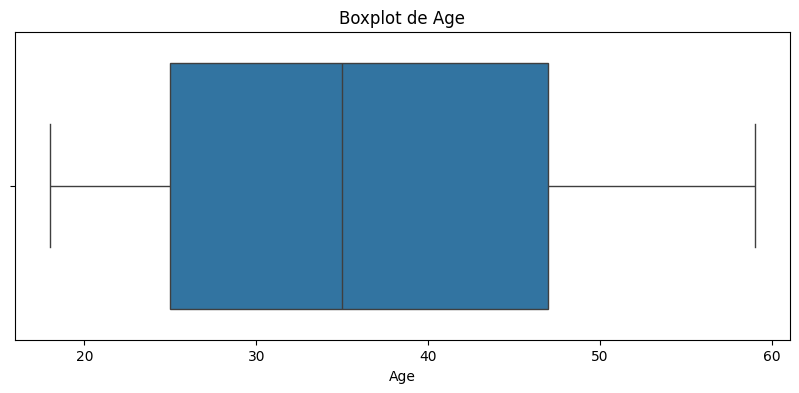

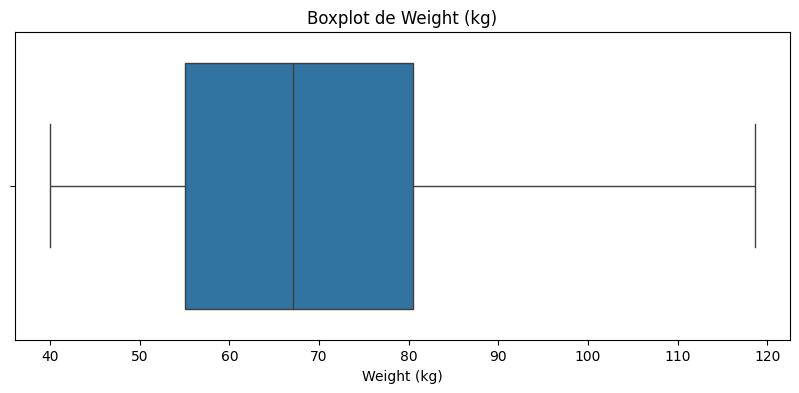

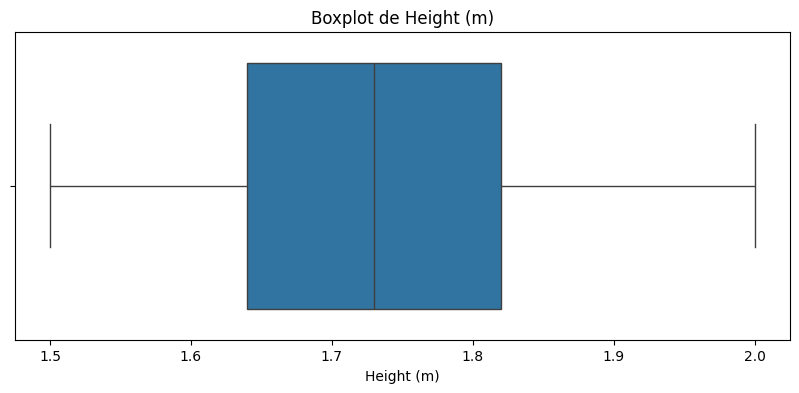

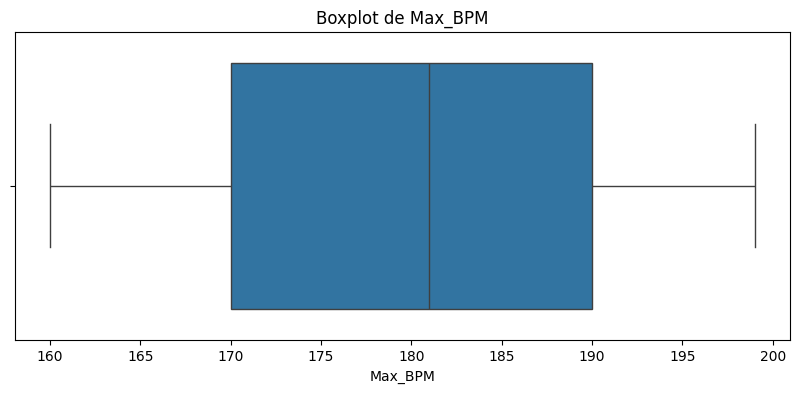

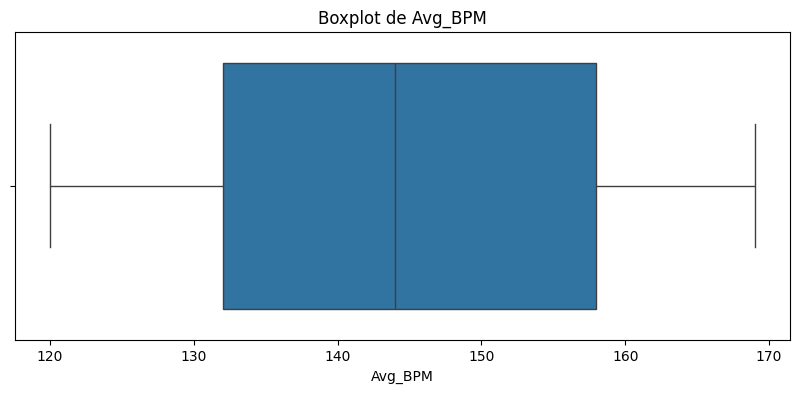

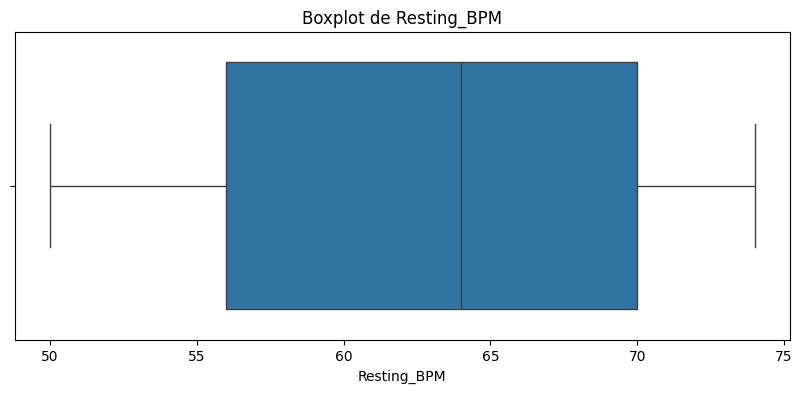

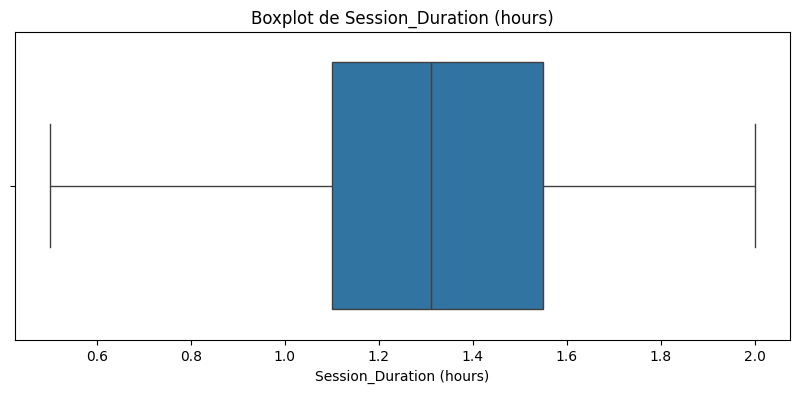

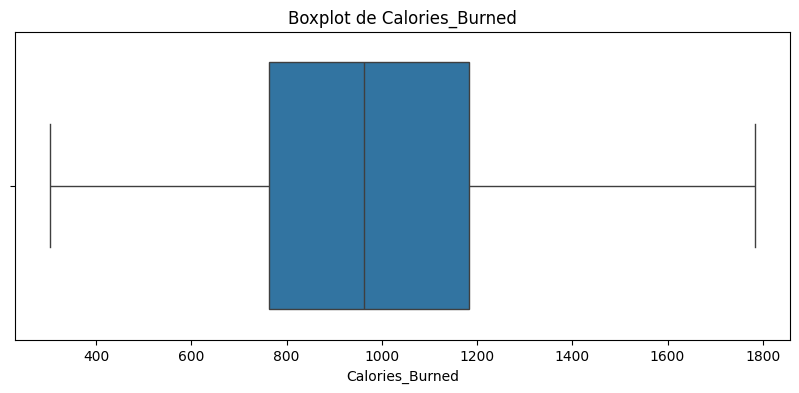

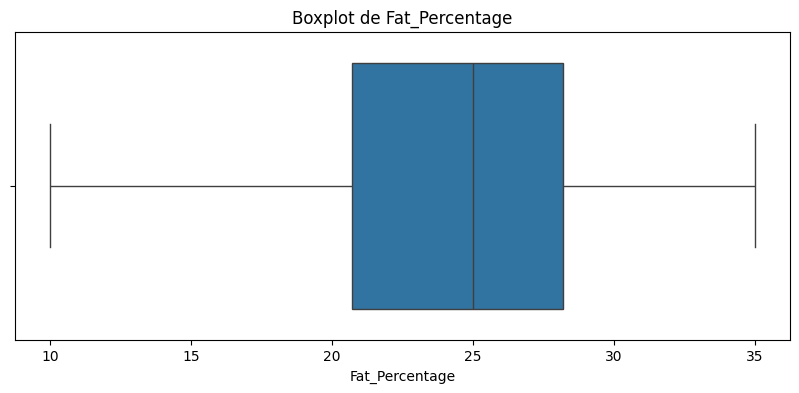

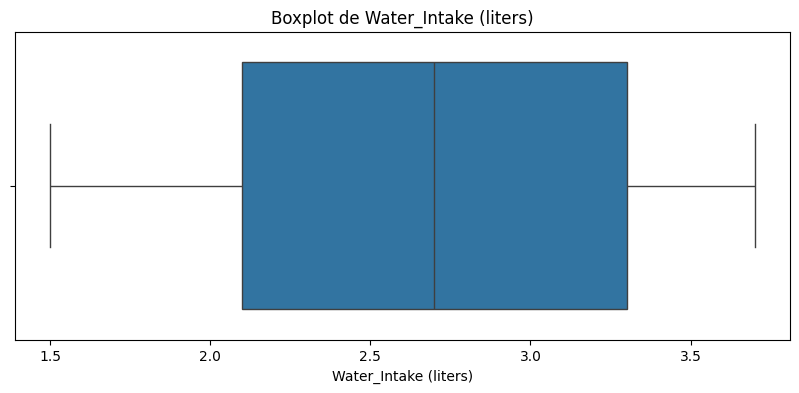

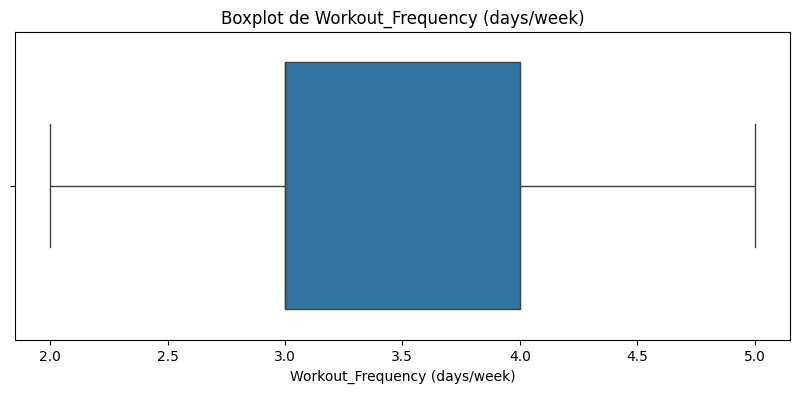

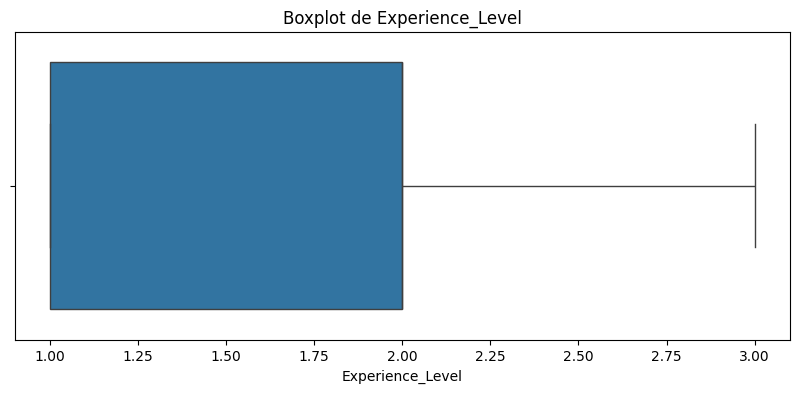

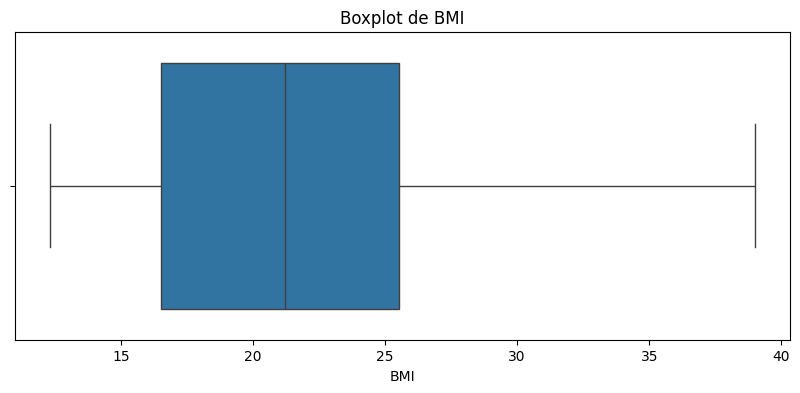

In [70]:
import seaborn as sns

def afficher_outliers(df):
    for col in df.select_dtypes(include='number').columns:
        plt.figure(figsize=(10, 4))
        sns.boxplot(data=df, x=col)
        plt.title(f"Boxplot de {col}")
        plt.show()

afficher_outliers(df)

In [71]:
for col in df.select_dtypes(include='number').columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    print(f"{col}: {len(outliers)} valeurs aberrantes")
df

Age: 0 valeurs aberrantes
Weight (kg): 0 valeurs aberrantes
Height (m): 0 valeurs aberrantes
Max_BPM: 0 valeurs aberrantes
Avg_BPM: 0 valeurs aberrantes
Resting_BPM: 0 valeurs aberrantes
Session_Duration (hours): 0 valeurs aberrantes
Calories_Burned: 0 valeurs aberrantes
Fat_Percentage: 0 valeurs aberrantes
Water_Intake (liters): 0 valeurs aberrantes
Workout_Frequency (days/week): 0 valeurs aberrantes
Experience_Level: 0 valeurs aberrantes
BMI: 0 valeurs aberrantes


,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI
0,56,Male,88.3,1.71,180,157,60,1.69,1313.0,Yoga,12.6,3.5,4,3,30.20
1,46,Female,74.9,1.53,179,151,66,1.30,883.0,HIIT,33.9,2.1,4,2,32.00
2,32,Female,68.1,1.66,167,122,54,1.11,677.0,Cardio,33.4,2.3,4,2,24.71
3,25,Male,53.2,1.70,190,164,56,0.59,532.0,Strength,28.8,2.1,3,1,18.41
4,38,Male,46.1,1.79,188,158,68,0.64,556.0,Strength,29.2,2.8,3,1,14.39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2768,54,Male,88.5,2.00,173,134,58,1.11,1388.0,HIIT,27.7,3.7,3,2,36.73
2769,52,Male,84.3,1.69,164,169,54,0.77,1367.0,HIIT,32.6,2.9,3,2,15.11
2770,47,Male,70.1,1.84,188,129,67,1.20,1261.0,Strength,28.4,2.5,3,2,17.99
2771,35,Male,49.3,1.71,180,152,73,1.04,956.0,Cardio,32.9,1.7,4,3,12.65


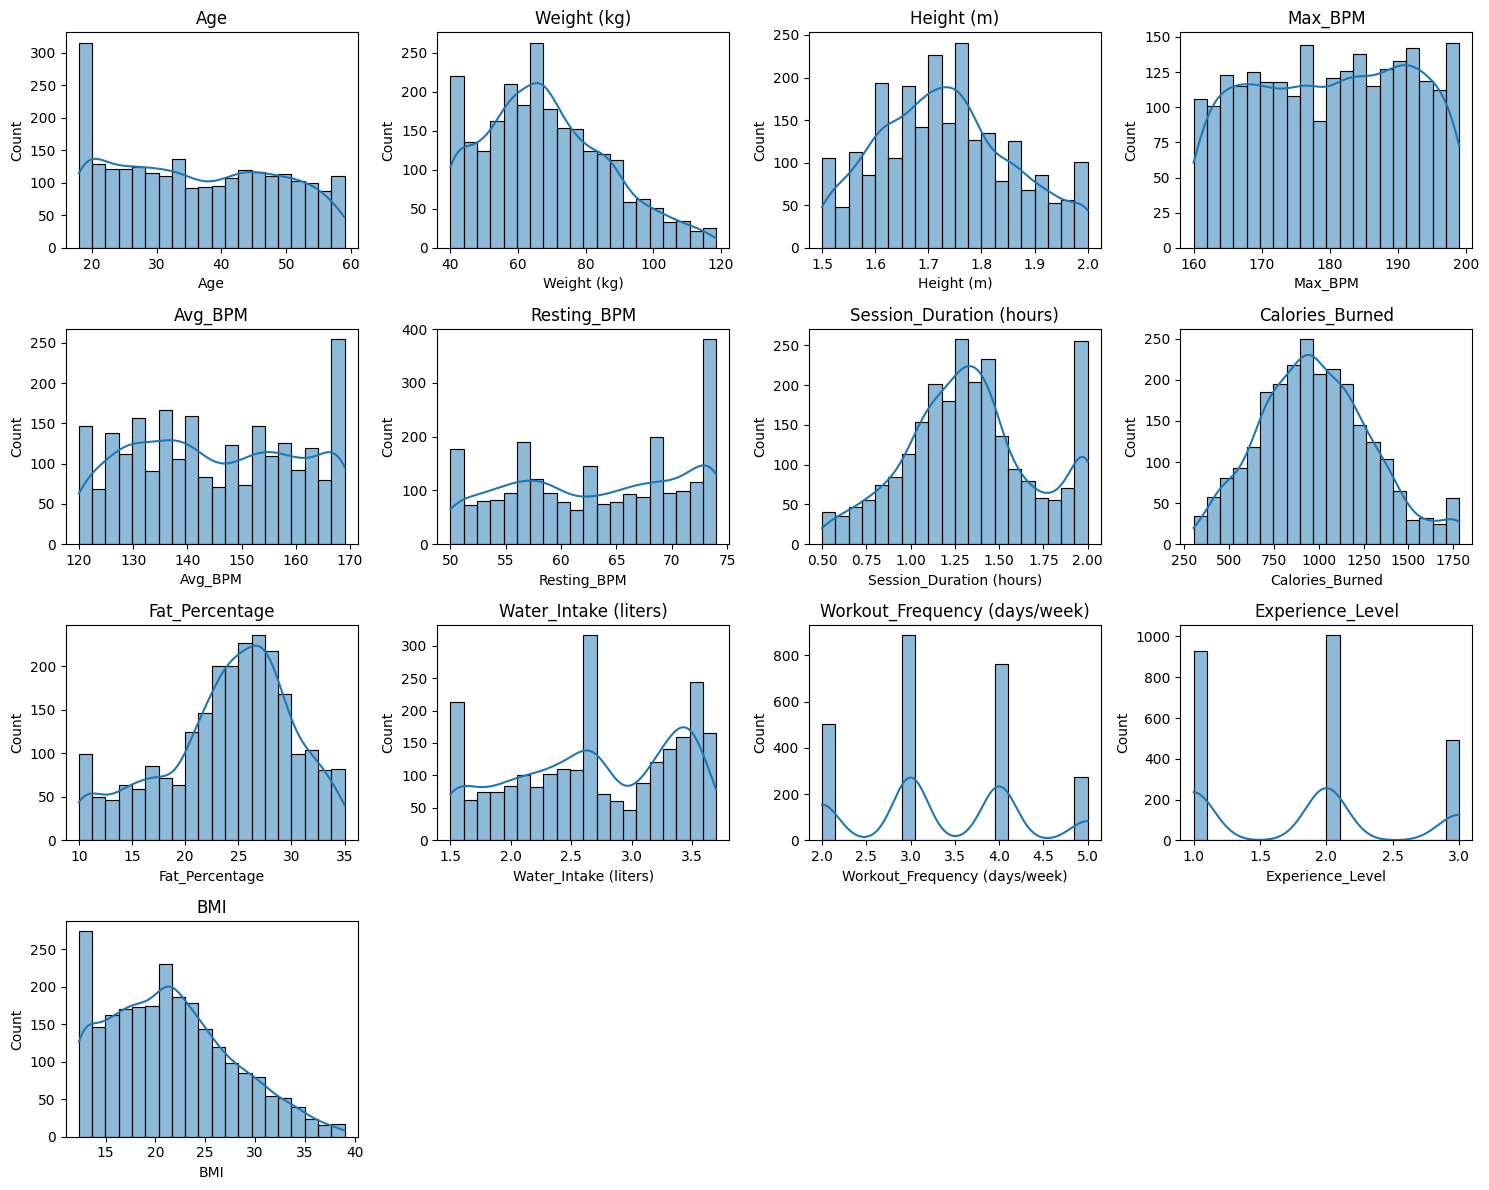

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_cols = df.select_dtypes(include=['number']).columns

plt.figure(figsize=(15, 12))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(4, 4, i)
    sns.histplot(df[col], kde=True, bins=20)
    plt.title(col)
plt.tight_layout()
plt.show()

- Interprétation
  
En regardant les histogrammes après nettoyage, on voit que le remplacement des outliers par la médiane a bien fonctionné. Les distributions sont maintenant beaucoup plus régulières et symétriques, surtout pour Weight, BMI, Session_Duration et Calories_Burned qui présentaient avant des formes irrégulières et une dispersion importante. Les variables cardiaques restent bien centrées et encore plus homogènes qu'avant. Globalement, les données sont maintenant bien nettoyées sans perte d'observations.

In [73]:
df_clean = df

In [74]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2427 entries, 0 to 2772
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Age                            2427 non-null   int64  
 1   Gender                         2427 non-null   object 
 2   Weight (kg)                    2427 non-null   float64
 3   Height (m)                     2427 non-null   float64
 4   Max_BPM                        2427 non-null   int64  
 5   Avg_BPM                        2427 non-null   int64  
 6   Resting_BPM                    2427 non-null   int64  
 7   Session_Duration (hours)       2427 non-null   float64
 8   Calories_Burned                2427 non-null   float64
 9   Workout_Type                   2427 non-null   object 
 10  Fat_Percentage                 2427 non-null   float64
 11  Water_Intake (liters)          2427 non-null   float64
 12  Workout_Frequency (days/week)  2427 non-null   int64 

- Observation
  
Le nettoyage a permis de passer de 2773 à 2427 observations, soit une perte de 346 lignes (environ 12,5%). Cette réduction s'explique principalement par la suppression des lignes contenant des valeurs incohérentes comme les zéros dans Age, Weight, Height ou Experience_Level, ainsi que le traitement des valeurs manquantes dans Gender et Workout_Type. Maintenant, toutes les colonnes ont exactement 2427 valeurs non-nulles, ce qui confirme qu'il n'y a plus de données manquantes

In [75]:
df_clean.describe()

,Age,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI
count,2427.000000,2427.000000,2427.000000,2427.000000,2427.000000,2427.000000,2427.000000,2427.000000,2427.000000,2427.000000,2427.000000,2427.000000,2427.000000
mean,36.194479,68.396044,1.732093,180.096415,145.100124,63.213020,1.336601,982.997940,24.048620,2.688175,3.331685,1.821590,21.451801
std,12.417514,18.282092,0.125736,11.486711,14.955232,7.727396,0.366412,311.240237,6.078033,0.665252,0.928613,0.744241,6.201544
min,18.000000,40.000000,1.500000,160.000000,120.000000,50.000000,0.500000,303.000000,10.000000,1.500000,2.000000,1.000000,12.320000
25%,25.000000,55.050000,1.640000,170.000000,132.000000,56.000000,1.100000,762.000000,20.700000,2.100000,3.000000,1.000000,16.520000
50%,35.000000,67.100000,1.730000,181.000000,144.000000,64.000000,1.310000,963.000000,25.000000,2.700000,3.000000,2.000000,21.200000
75%,47.000000,80.500000,1.820000,190.000000,158.000000,70.000000,1.550000,1182.500000,28.200000,3.300000,4.000000,2.000000,25.515000
max,59.000000,118.600000,2.000000,199.000000,169.000000,74.000000,2.000000,1783.000000,35.000000,3.700000,5.000000,3.000000,38.990000


- Observation

Les valeurs minimales sont devenues réalistes : l'âge minimum est de 18 ans (au lieu de 0), le poids commence à 40 kg, la taille à 1,50 m, et l'Experience_Level débute correctement à 1. Le remplacement des outliers par la médiane a également resserré les distributions, ce qui se voit dans les écarts-types légèrement réduits pour certaines variables comme Weight et BMI.
Les valeurs moyennes sont restées globalement stables, ce qui indique que le nettoyage n'a pas biaisé l'ensemble du dataset mais a simplement corrigé les anomalies. Les plages de valeurs (min-max) sont maintenant cohérentes et exploitables pour la modélisation. Le dataset est désormais propre, complet et prêt pour l'analyse.

In [76]:
df_clean

,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI
0,56,Male,88.3,1.71,180,157,60,1.69,1313.0,Yoga,12.6,3.5,4,3,30.20
1,46,Female,74.9,1.53,179,151,66,1.30,883.0,HIIT,33.9,2.1,4,2,32.00
2,32,Female,68.1,1.66,167,122,54,1.11,677.0,Cardio,33.4,2.3,4,2,24.71
3,25,Male,53.2,1.70,190,164,56,0.59,532.0,Strength,28.8,2.1,3,1,18.41
4,38,Male,46.1,1.79,188,158,68,0.64,556.0,Strength,29.2,2.8,3,1,14.39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2768,54,Male,88.5,2.00,173,134,58,1.11,1388.0,HIIT,27.7,3.7,3,2,36.73
2769,52,Male,84.3,1.69,164,169,54,0.77,1367.0,HIIT,32.6,2.9,3,2,15.11
2770,47,Male,70.1,1.84,188,129,67,1.20,1261.0,Strength,28.4,2.5,3,2,17.99
2771,35,Male,49.3,1.71,180,152,73,1.04,956.0,Cardio,32.9,1.7,4,3,12.65


## Création de la variable cible : Risque de surentraînement

### Objectif
Créer une colonne binaire `Overtraining_Risk` (0 = faible risque, 1 = risque élevé) en se basant sur des valeurs de référence scientifiques pour évaluer si un individu présente des signes de surentraînement.

### Méthodologie

#### Étape 1 : Construction des données de référence
Nous avons créé des tableaux de valeurs normales ajustées selon l'âge et le sexe, basés sur des sources médicales reconnues :

**Sources utilisées :**
- **Fréquence cardiaque au repos** : American Heart Association (AHA) 2024, National Institutes of Health (NIH) 2023
- **Pourcentage de masse grasse** : American Council on Exercise (ACE) 2024
- **Fréquence cardiaque maximale** : Formule de Tanaka et al., Journal of the American College of Cardiology (JACC) 2001
- **Indice de Masse Corporelle (IMC)** : Organisation Mondiale de la Santé (OMS) 2024

#### Étape 2 : Calcul du score de risque
Pour chaque individu, nous calculons un score de risque basé sur plusieurs indicateurs physiologiques :

1. **Fréquence cardiaque au repos élevée** : Un resting BPM supérieur aux valeurs normales pour l'âge indique un stress physiologique (principal indicateur de surentraînement)

2. **Réserve cardiaque faible** : Différence entre FC max et FC repos < seuils attendus (signe de fatigue cardiovasculaire)

3. **Composition corporelle déséquilibrée** : 
   - Masse grasse trop basse (< seuil essentiel) -> récupération compromise
   - Masse grasse trop élevée (> seuil obésité) -> stress métabolique

4. **Charge d'entraînement excessive** : Fréquence * durée des séances trop élevée

5. **Durée de séance prolongée** : Sessions > 2h augmentent le risque de fatigue

6. **Hydratation insuffisante** : Apport en eau < 2L compromet la récupération

7. **IMC anormal** : Maigreur ou obésité amplifient le stress physiologique

8. **Efficacité calorique faible** : Calories brûlées/heure < seuils -> signe de fatigue

9. **Niveau d'expérience** : Les débutants sont plus vulnérables

#### Étape 3 : Classification finale
- **Score de risque ≥ 7** -> `Overtraining_Risk = 1` (Risque ÉLEVÉ)
- **Score de risque 4-6** -> `Overtraining_Risk = 1` (Risque MODÉRÉ)
- **Score de risque < 4** -> `Overtraining_Risk = 0` (Risque FAIBLE)

---

### Références complètes

1. **American Heart Association (AHA).** "Target Heart Rates Chart." 2024. 
   https://www.heart.org/en/healthy-living/fitness/fitness-basics/target-heart-rates

2. **National Institutes of Health (NIH).** "Resting Heart Rate Reference Data." National Health Statistics Reports. 2023.

3. **American Council on Exercise (ACE).** "Body Fat Percentage Norms." 2024.

4. **Tanaka H, Monahan KD, Seals DR.** "Age-predicted maximal heart rate revisited." 
   Journal of the American College of Cardiology. 2001;37(1):153-156.

5. **Organisation Mondiale de la Santé (OMS).** "Classification de l'IMC." 2024.

In [77]:
df_clean.Age.min(), df.Age.max()

(18, 59)

In [78]:
ages = df_clean.Age.unique()
ages.sort()
ages

array([18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59])

In [79]:
# ============================================================================
# RÉFÉRENCES : Valeurs normales selon âge et sexe
# Sources : AHA 2024, NIH 2023, ACE 2024
# ============================================================================

# 1. Fréquence cardiaque au repos (BPM) selon l'âge
resting_hr_reference = pd.DataFrame({
    'Age_Min': [18, 26, 36, 46, 56, 66],
    'Age_Max': [25, 35, 45, 55, 65, 100],
    'Normal_Min': [60, 61, 62, 63, 64, 65],
    'Normal_Max': [80, 80, 81, 82, 83, 84],
    'Athlete_Min': [40, 41, 42, 43, 44, 45],
    'Athlete_Max': [54, 55, 56, 57, 58, 60]
})

# 2. Pourcentage de masse grasse (Body Fat %) selon le sexe et l'âge
body_fat_reference = pd.DataFrame({
    'Sexe': ['Male', 'Male', 'Male', 'Male', 'Female', 'Female', 'Female', 'Female'],
    'Age_Min': [18, 30, 40, 50, 18, 30, 40, 50],
    'Age_Max': [29, 39, 49, 100, 29, 39, 49, 100],
    'Essentiel_Max': [5, 5, 5, 5, 13, 13, 13, 13],
    'Athlète_Min': [6, 6, 7, 8, 14, 15, 16, 17],
    'Athlète_Max': [13, 14, 15, 16, 21, 22, 23, 24],
    'Fitness_Max': [17, 18, 19, 20, 25, 26, 27, 28],
    'Acceptable_Max': [24, 25, 26, 27, 31, 32, 33, 34],
    'Obésité_Seuil': [25, 26, 27, 28, 32, 33, 34, 35]
})

# 3. Fréquence cardiaque maximale théorique (formule Tanaka et al., JACC 2001)
def get_max_hr_expected(age):
    return 208 - (0.7 * age)

# 4. IMC de référence selon OMS 2024
bmi_reference = {
    'Maigreur': 18.5,
    'Normal': 24.9,
    'Surpoids': 29.9,
    'Obésité classe I': 34.9,
    'Obésité classe II': 39.9,
    'Obésité classe III': 40.0
}

In [80]:
def get_resting_hr_range(age):
    """Obtenir la plage normale de fréquence cardiaque au repos pour l'age en paramètre"""
    ref = resting_hr_reference[
        (resting_hr_reference['Age_Min'] <= age) & 
        (resting_hr_reference['Age_Max'] >= age)
    ]
    if len(ref) > 0:
        return ref.iloc[0]['Normal_Min'], ref.iloc[0]['Normal_Max']
    
    # Si on n'a pas trouvé l'age dans le tableau de référence
    if age < 18:
        return 70, 100
    elif age > 100:
        return 65, 100

def get_body_fat_range(age, gender):
    """Get normal body fat range for age and gender"""
    ref = body_fat_reference[
        (body_fat_reference['Sexe'] == gender) &
        (body_fat_reference['Age_Min'] <= age) & 
        (body_fat_reference['Age_Max'] >= age)
    ]
    if len(ref) > 0:
        return (ref.iloc[0]['Essentiel_Max'], ref.iloc[0]['Acceptable_Max'], ref.iloc[0]['Obésité_Seuil'])
    
    if gender == 'Male':
        return 5, 21, 28
    else :
        return 13, 20, 32

In [81]:
def calculate_overtraining_risk(row):
    """
    Calcule le risque de surentraînement en fonction des valeurs de référence ajustées en fonction de l'âge et du sexe
    Returns: risk_score (int), risk_level (str), details (dict)
    """
    risk_score = 0
    details = {}
    
    age = row['Age']
    gender = row['Gender']
    
    # -------------------------------------------------------------------------
    # 1. ANALYSE DU BPM AU REPOS 
    # -------------------------------------------------------------------------
    hr_min, hr_max = get_resting_hr_range(age)
    resting_bpm = row['Resting_BPM']
    
    if resting_bpm > hr_max + 10:
        risk_score += 3  # Sévèrement élevé
        details['Resting_HR'] = f"Severely elevated ({resting_bpm} vs normal {hr_min}-{hr_max})"
    elif resting_bpm > hr_max + 5:
        risk_score += 2  # Modérément élevé
        details['Resting_HR'] = f"Elevated ({resting_bpm} vs normal {hr_min}-{hr_max})"
    elif resting_bpm > hr_max:
        risk_score += 1  # Légèrement élevé
        details['Resting_HR'] = f"Slightly elevated ({resting_bpm} vs normal {hr_min}-{hr_max})"
    else:
        details['Resting_HR'] = "Normal"
    
    # -------------------------------------------------------------------------
    # 2. BPM RESERVE (Max BPM - BPM au repos)
    # -------------------------------------------------------------------------
    expected_max_hr = get_max_hr_expected(age)
    hr_reserve = row['Max_BPM'] - row['Resting_BPM']
    expected_reserve = expected_max_hr - hr_max
    
    # Une faible réserve cardiaque indique une mauvaise condition physique cardiovasculaire ou un surentraînement
    if hr_reserve < expected_reserve * 0.7:  # Moins que 70% attendu
        risk_score += 2
        details['HR_Reserve'] = f"Low reserve ({hr_reserve} vs expected ~{expected_reserve})"
    elif hr_reserve < expected_reserve * 0.85:
        risk_score += 1
        details['HR_Reserve'] = f"Below average ({hr_reserve} vs expected ~{expected_reserve})"
    else:
        details['HR_Reserve'] = "Adequate"
    
    # -------------------------------------------------------------------------
    # 3. POURCENTAGE DU BODY FAT 
    # -------------------------------------------------------------------------
    essential, normal, high = get_body_fat_range(age, gender)
    fat_pct = row['Fat_Percentage']
    
    if fat_pct < essential:
        risk_score += 2  # Too low - hormonal issues, poor recovery
        details['Body_Fat'] = f"Dangerously low ({fat_pct}% vs min {essential}%)"
    elif fat_pct > high:
        risk_score += 1  # Too high - metabolic stress
        details['Body_Fat'] = f"High ({fat_pct}% vs normal max {normal}%)"
    elif fat_pct > normal:
        risk_score += 0.5
        details['Body_Fat'] = f"Above normal ({fat_pct}% vs normal max {normal}%)"
    else:
        details['Body_Fat'] = "Normal range"
    
    # -------------------------------------------------------------------------
    # 4. VOLUME D'ENTRAÎNEMENT (Fréquence * Durée)
    # -------------------------------------------------------------------------
    workout_freq = row['Workout_Frequency (days/week)']
    session_duration = row['Session_Duration (hours)']
    training_load = workout_freq * session_duration
    
    if training_load > 12:  # ex: 6j * 2h
        risk_score += 3
        details['Training_Load'] = f"Excessive ({training_load:.1f} hrs/week)"
    elif training_load > 10:
        risk_score += 2
        details['Training_Load'] = f"Very high ({training_load:.1f} hrs/week)"
    elif training_load > 8:
        risk_score += 1
        details['Training_Load'] = f"High ({training_load:.1f} hrs/week)"
    else:
        details['Training_Load'] = "Moderate"
    
    # Une seule séance très longue
    if session_duration > 2.5:
        risk_score += 1
        details['Session_Duration'] = f"Very long sessions ({session_duration} hrs)"
    elif session_duration > 2.0:
        risk_score += 0.5
        details['Session_Duration'] = f"Long sessions ({session_duration} hrs)"
    
    # -------------------------------------------------------------------------
    # 5. INDICATEURS DE RÉCUPÉRATION
    # -------------------------------------------------------------------------
    # Eau
    water_intake = row['Water_Intake (liters)']
    if water_intake < 2.0:
        risk_score += 1
        details['Hydration'] = f"Low water intake ({water_intake}L)"
    elif water_intake < 2.5:
        risk_score += 0.5
        details['Hydration'] = f"Suboptimal hydration ({water_intake}L)"
    else:
        details['Hydration'] = "Adequate"
    
    # -------------------------------------------------------------------------
    # 6. NIVEAU D'EXPÉRIENCE
    # -------------------------------------------------------------------------
    experience = row['Experience_Level']
    
    # Les débutants sont plus susceptibles de souffrir de surentraînement
    if experience == 1:  # Débutant
        risk_score *= 1.3  # augmentation du risque de 30%
        details['Experience'] = "Beginner (higher susceptibility)"
    elif experience == 2:  # Intermédiaire
        risk_score *= 1.1  # augmentation de 10%
        details['Experience'] = "Intermediate"
    else:  # Avancé
        details['Experience'] = "Advanced"
    
    # -------------------------------------------------------------------------
    # 7. CONSIDÉRATION DE L'IMC (selon OMS 2024)
    # -------------------------------------------------------------------------
    bmi = row['BMI']

    # Maigreur
    if bmi < bmi_reference['Maigreur']:
        risk_score += 2  # Risque élevé : récupération compromise, déficit énergétique
        details['BMI'] = f"Maigreur ({bmi:.1f}, norme < {bmi_reference['Maigreur']})"

    # Normal (pas de pénalité)
    elif bmi <= bmi_reference['Normal']:
        details['BMI'] = f"Normal ({bmi:.1f})"

    # Surpoids (léger risque)
    elif bmi <= bmi_reference['Surpoids']:
        risk_score += 1  # Charge métabolique et articulaire accrue
        details['BMI'] = f"Surpoids ({bmi:.1f}, norme {bmi_reference['Normal']}-{bmi_reference['Surpoids']})"

    # Obésité classe I (risque modéré)
    elif bmi <= bmi_reference['Obésité classe I']:
        risk_score += 2
        details['BMI'] = f"Obésité classe I ({bmi:.1f}, norme {bmi_reference['Surpoids']}-{bmi_reference['Obésité classe I']})"

    # Obésité classe II (risque élevé)
    elif bmi <= bmi_reference['Obésité classe II']:
        risk_score += 3
        details['BMI'] = f"Obésité classe II ({bmi:.1f}, norme {bmi_reference['Obésité classe I']}-{bmi_reference['Obésité classe II']})"

    # Obésité classe III (risque très élevé)
    else:
        risk_score += 4
        details['BMI'] = f"Obésité classe III ({bmi:.1f}, ≥ {bmi_reference['Obésité classe III']})"
    
    # -------------------------------------------------------------------------
    # 8. EFFICACITÉ CALORIQUE
    # -------------------------------------------------------------------------
    calories_burned = row['Calories_Burned']
    calories_per_hour = calories_burned / session_duration if session_duration > 0 else 0
    
    # Une très faible dépense calorique peut indiquer de la fatigue ou une inefficacité
    if calories_per_hour < 250:
        risk_score += 1
        details['Caloric_Efficiency'] = f"Low efficiency ({calories_per_hour:.0f} cal/hr)"
    
    # -------------------------------------------------------------------------
    # CLASSIFICATION FINALE
    # -------------------------------------------------------------------------
    if risk_score >= 7:
        risk_level = "HIGH"
        risk_binary = 1
    elif risk_score >= 4:
        risk_level = "MODERATE"
        risk_binary = 1
    else:
        risk_level = "LOW"
        risk_binary = 0
    
    return risk_binary, risk_level, risk_score

In [82]:
# ============================================================================
# APPLY TO DATAFRAME
# ============================================================================

def add_overtraining_risk_column(df):
    """
    Ajouter des colonnes de risque de surentraînement au dataframe.
    
    Paramètres :
    df : DataFrame avec les colonnes requises.
    
    Résultats :
    DataFrame avec les colonnes ajoutées :
        - Overtraining_Risk (binaire : 0 ou 1)
        - Risk_Level (LOW, MODERATE, HIGH)
        - Risk_Score (score continu)
        - Risk_Details (dictionnaire avec explication)
    """
    results = df.apply(calculate_overtraining_risk, axis=1, result_type='expand')
    results.columns = ['Overtraining_Risk', 'Risk_Level', 'Risk_Score']
    
    df_with_risk = pd.concat([df, results], axis=1)
    
    return df_with_risk

In [83]:
new_df = add_overtraining_risk_column(df_clean)
new_df

,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI,Overtraining_Risk,Risk_Level,Risk_Score
0,56,Male,88.3,1.71,180,157,60,1.69,1313.0,Yoga,12.6,3.5,4,3,30.20,0,LOW,2.00
1,46,Female,74.9,1.53,179,151,66,1.30,883.0,HIIT,33.9,2.1,4,2,32.00,0,LOW,3.10
2,32,Female,68.1,1.66,167,122,54,1.11,677.0,Cardio,33.4,2.3,4,2,24.71,0,LOW,1.65
3,25,Male,53.2,1.70,190,164,56,0.59,532.0,Strength,28.8,2.1,3,1,18.41,0,LOW,3.95
4,38,Male,46.1,1.79,188,158,68,0.64,556.0,Strength,29.2,2.8,3,1,14.39,0,LOW,3.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2768,54,Male,88.5,2.00,173,134,58,1.11,1388.0,HIIT,27.7,3.7,3,2,36.73,0,LOW,3.55
2769,52,Male,84.3,1.69,164,169,54,0.77,1367.0,HIIT,32.6,2.9,3,2,15.11,0,LOW,3.10
2770,47,Male,70.1,1.84,188,129,67,1.20,1261.0,Strength,28.4,2.5,3,2,17.99,0,LOW,3.10
2771,35,Male,49.3,1.71,180,152,73,1.04,956.0,Cardio,32.9,1.7,4,3,12.65,1,MODERATE,4.00


In [84]:
new_df[new_df['Risk_Level'] == 'LOW'].shape, new_df[new_df['Risk_Level'] == 'MODERATE'].shape, new_df[new_df['Risk_Level'] == 'HIGH'].shape

((2324, 18), (102, 18), (1, 18))

**Remarque:** Il faudra utiliser un moyen d'augmenter le nombre de MODERATE pour éviter le underfitting 